<a href="https://colab.research.google.com/github/psychemistz/MultiDimGCNR/blob/main/UNET_weather_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wget
import tensorflow as tf
import keras.backend as K
import cv2
from sklearn.model_selection import train_test_split

import keras
from os import path
import h5py
import numpy as np
import matplotlib.pyplot as plt
import gc
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import scipy
import wget
import cv2

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Model
from keras.models import load_model
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
from scipy.io import savemat
from random import sample

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ed3ae6ba0ba35b23a79b6cf7b5ce7f7f29056964272588fa7584040e28681902
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
classes = ('cloudy','rain','shine','sunrise')
data_path = 'https://raw.githubusercontent.com/Shujaat123/Weather_Classification/master/dataset/'

flist = []
for fname in classes:
  filename = 'WeatherClassificationDB_'+fname+'.mat'
  if(path.exists(filename)):
    !rm $filename
    print('existing file:', filename, ' has been deleted')
  print('downloading latest version of file:', filename)
  file_path = data_path + filename
  wget.download(file_path, filename)
  print('DONE')
  flist.append(filename)

downloading latest version of file: WeatherClassificationDB_cloudy.mat
DONE
downloading latest version of file: WeatherClassificationDB_rain.mat
DONE
downloading latest version of file: WeatherClassificationDB_shine.mat
DONE
downloading latest version of file: WeatherClassificationDB_sunrise.mat
DONE


In [ ]:
cloudy_imgs = h5py.File(flist[0], 'r')['images']['input']
cloudy_labels = h5py.File(flist[0], 'r')['images']['label']

rain_imgs = h5py.File(flist[1], 'r')['images']['input']
rain_labels = h5py.File(flist[1], 'r')['images']['label']

shine_imgs = h5py.File(flist[2], 'r')['images']['input']
shine_labels = h5py.File(flist[2], 'r')['images']['label']

sunrise_imgs = h5py.File(flist[3], 'r')['images']['input']
sunrise_labels = h5py.File(flist[3], 'r')['images']['label']

In [ ]:
print(cloudy_imgs.shape) # (NHWC)
print(cloudy_labels.shape)

print(rain_imgs.shape) # (NHWC)
print(rain_labels.shape)

print(shine_imgs.shape) # (NHWC)
print(shine_labels.shape)

print(sunrise_imgs.shape) # (NHWC)
print(sunrise_labels.shape)


InputImages = np.concatenate((cloudy_imgs,rain_imgs,shine_imgs,sunrise_imgs), axis = 0)
InputImages = InputImages/InputImages.max()
ClassLabels = np.concatenate((cloudy_labels,rain_labels,shine_labels,sunrise_labels), axis = 0)

InputImages.shape
ClassLabels.shape
# ClassLabels = to_categorical(np.int8(np.squeeze(ClassLabels))-1)
ClassLabels = to_categorical(np.squeeze(ClassLabels)-1)
ClassLabels.shape

(207, 256, 256, 3)
(207, 1, 1, 1)
(215, 256, 256, 3)
(215, 1, 1, 1)
(253, 256, 256, 3)
(253, 1, 1, 1)
(357, 256, 256, 3)
(357, 1, 1, 1)


(1032, 4)

In [ ]:
cloudy_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==0)).flatten())
rain_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==1)).flatten())
shine_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==2)).flatten())
sunrise_list = list(np.asarray(np.where(ClassLabels.argmax(axis=1)==3)).flatten())
total_list = cloudy_list + rain_list + shine_list + sunrise_list

print('Number of \'cloudy\' samples:',len(cloudy_list))
print('Number of \'rain\' samples:',len(rain_list))
print('Number of \'shine\' samples:',len(shine_list))
print('Number of \'sunrise\' samples:',len(sunrise_list))
print('Total number of samples:',len(total_list))

Number of 'cloudy' samples: 207
Number of 'rain' samples: 215
Number of 'shine' samples: 253
Number of 'sunrise' samples: 357
Total number of samples: 1032


In [ ]:
cloudy_train = sample(cloudy_list, 150)
rain_train = sample(rain_list, 150)
shine_train = sample(shine_list, 150)
sunrise_train = sample(sunrise_list, 150)
train_list = cloudy_train + rain_train + shine_train + sunrise_train

Input_train = InputImages[train_list]
Label_train = ClassLabels[train_list]

# valid select 20 cloudy, 20 rain, 20 shine and 20 sunrise samples
cloudy_val = sample(set(cloudy_list) - set(cloudy_train), 20)
rain_val = sample(set(rain_list) - set(rain_train), 20)
shine_val = sample(set(shine_list) - set(shine_train), 20)
sunrise_val = sample(set(sunrise_list) - set(sunrise_train), 20)
val_list = cloudy_val + rain_val + shine_val + sunrise_val

Input_val = InputImages[val_list]
Label_val = ClassLabels[val_list]

## test
test_list = list(set(total_list) - set(train_list) - set(val_list))

# test_list
Input_test = InputImages[test_list]
Label_test = ClassLabels[test_list]

In [ ]:
norm_train = Input_train/np.max(np.abs(Input_train))
norm_test = Input_test/np.max(np.abs(Input_test))
norm_val = Input_val/np.max(np.abs(Input_test))
print(norm_train.shape, norm_test.shape, norm_val.shape)

(600, 256, 256, 3) (352, 256, 256, 3) (80, 256, 256, 3)


In [ ]:
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
print(norm_train.shape)
temp = np.empty((1,64,64,3))
for i in range(0, norm_train.shape[0]):
  patches = image.extract_patches_2d(norm_train[i], (64, 64), random_state=40, max_patches=4)
  temp = np.concatenate((temp,patches), axis = 0)
norm_train = np.asarray(temp[1:])
print(norm_train.shape)

print(norm_val.shape)
temp = np.empty((1,64,64,3))
for i in range(0, norm_val.shape[0]):
  patches = image.extract_patches_2d(norm_val[i], (64, 64), random_state=40, max_patches=4)
  temp = np.concatenate((temp,patches), axis = 0)
norm_val = np.asarray(temp[1:])
print(norm_val.shape)
gc.collect()

(600, 256, 256, 3)
(2400, 64, 64, 3)
(80, 256, 256, 3)
(320, 64, 64, 3)


33

In [ ]:
norm_train = np.asarray(norm_train)
norm_val = np.asarray(norm_val)
norm_test = np.asarray(norm_test)

In [ ]:
noise_factor_normal = 0.05
x_train = norm_train + noise_factor_normal * np.random.normal(size=norm_train.shape)
x_val = norm_val + noise_factor_normal * np.random.normal(size=norm_val.shape)
x_test = norm_test + noise_factor_normal * np.random.normal(size=norm_test.shape)

In [ ]:
x_train = x_train/np.max(np.abs(x_train))
x_val = x_val/np.max(np.abs(x_val))
x_test = x_test/np.max(np.abs(x_test))

x_train = np.clip(x_train, 0., 1.)
x_val = np.clip(x_val, 0., 1.)
x_test = np.clip(x_test, 0., 1.)

In [ ]:
def enc_conv_block(in_conv, num_filter = 32, kernel_size = 3):
  x = Conv2D(num_filter, kernel_size, padding='same')(in_conv)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = Conv2D(num_filter, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  SC = Activation(activation='relu')(x)
  x = MaxPooling2D(pool_size=(2,2))(SC)
  x = Conv2D(num_filter, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  y = Activation(activation='relu')(x)
  return y, SC 

def dec_deconv_block(encoder_output, SC, num_filter = 256, kernel_size = 3):
  x  = Conv2DTranspose(num_filter, kernel_size, strides = (2,2), padding='same')(encoder_output)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = Concatenate()([x, SC])
  x = Conv2D(num_filter, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activation='relu')(x)
  x = Conv2D(num_filter, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  y = Activation(activation='relu')(x)
  return y

def my_model():
  num_filter = 32
  kernel_size = 3
  
  input_img = Input(shape = (None, None, 3), name = 'input_img')
  green = Conv2D(num_filter, kernel_size, activation='relu', padding='same', name = 'green')(input_img)
  CB_1 , SC1 = enc_conv_block(green, num_filter, kernel_size)
  CB_2 , SC2 = enc_conv_block(CB_1, 2*num_filter, kernel_size)
  CB_3 , SC3 = enc_conv_block(CB_2, 4*num_filter, kernel_size)
  CB_4 , SC4 = enc_conv_block(CB_3, 8*num_filter, kernel_size)
  
  CB5, SC5 = enc_conv_block(CB_4, 16*num_filter, kernel_size)
  
  DCB1 = dec_deconv_block(SC5, SC4, 8*num_filter, kernel_size)
  DCB2 = dec_deconv_block(DCB1, SC3, 4*num_filter, kernel_size)  
  DCB3 = dec_deconv_block(DCB2, SC2, 2*num_filter, kernel_size)
  DCB4 = dec_deconv_block(DCB3, SC1, num_filter, kernel_size)

  # x = Conv2D(1, (1,1), padding= 'same', name='1by1conv')(DCB4)
  # output = Add(name='output')([x, input_img])
  output = Conv2D(3, (1,1), padding= 'same', activation= 'sigmoid', name='output')(DCB4)

  model = Model(inputs=[input_img], outputs=[output])
  model.compile(optimizer=Adam(learning_rate = 7e-4), 
                loss={ 'output': 'mean_squared_error'})

  return model

model = my_model()
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 green (Conv2D)                 (None, None, None,   896         ['input_img[0][0]']              
                                32)                                                               
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   9248        ['green[0][0]']                  
                                32)                                                           

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
  
checkpoint = ModelCheckpoint('models\\model-best.h5',
                                  verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

del model
model = my_model()
history = model.fit(x_train, norm_train,
                        validation_data = (x_val, norm_val),
                        epochs=200, batch_size=16, callbacks=[checkpoint, es], verbose=1)

del model
from tensorflow import keras
model = keras.models.load_model('models\\model-best.h5')

Epoch 1/200
150/150 [==============================] - ETA: 0s - loss: 0.0112
Epoch 1: val_loss improved from inf to 0.04352, saving model to models\model-best.h5
150/150 [==============================] - 37s 156ms/step - loss: 0.0112 - val_loss: 0.0435
Epoch 2/200
150/150 [==============================] - ETA: 0s - loss: 0.0054
Epoch 2: val_loss improved from 0.04352 to 0.01664, saving model to models\model-best.h5
150/150 [==============================] - 23s 151ms/step - loss: 0.0054 - val_loss: 0.0166
Epoch 3/200
150/150 [==============================] - ETA: 0s - loss: 0.0047
Epoch 3: val_loss improved from 0.01664 to 0.00431, saving model to models\model-best.h5
150/150 [==============================] - 22s 147ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/200
150/150 [==============================] - ETA: 0s - loss: 0.0042
Epoch 4: val_loss improved from 0.00431 to 0.00357, saving model to models\model-best.h5
150/150 [==============================] - 22s 144ms/step - 

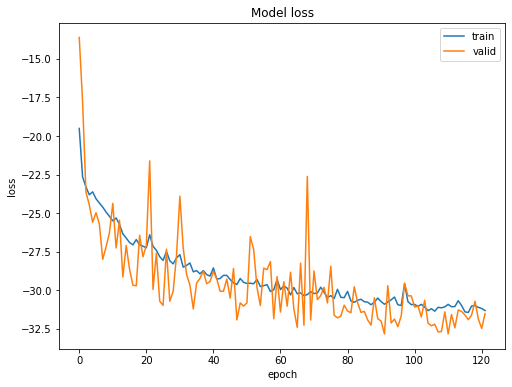

In [ ]:
plt.figure(1, figsize = (8,6))
plt.plot(10*np.log10(history.history['loss']))
plt.plot(10*np.log10(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

In [ ]:
from tensorflow.image import psnr

def Calculate_Noise_vs_Stats(x_train, x_val, x_test, norm_train, norm_val, norm_test,noise_factor_normal,model):
  
  x_train = norm_train + noise_factor_normal * np.random.normal(size=norm_train.shape)
  x_val = norm_val + noise_factor_normal * np.random.normal(size=norm_val.shape)
  x_test = norm_test + noise_factor_normal * np.random.normal(size=norm_test.shape)

  x_train = x_train/np.max(np.abs(x_train))
  x_val = x_val/np.max(np.abs(x_val))
  x_test = x_test/np.max(np.abs(x_test))
  
  train_pred = model.predict(x_train)
  val_pred = model.predict(x_val)
  test_pred = model.predict(x_test)


  # predicted_uniform = np.clip(predicted_uniform, 0., 1.)
  train_pred = np.clip(train_pred, 0., 1.)
  val_pred = np.clip(val_pred, 0., 1.)
  test_pred = np.clip(test_pred, 0., 1.)

  # psnr_uniform_pred = psnr(predicted_uniform, x_test, max_val=1.0)
  psnr_train_input = psnr(x_train, norm_train, max_val=1.0)
  psnr_val_input = psnr(x_val, norm_val, max_val=1.0)
  psnr_test_input = psnr(x_test, norm_test, max_val=1.0)

  psnr_pred_output_train = psnr(train_pred, x_train, max_val=1.0)
  psnr_pred_output_val = psnr(val_pred, x_val, max_val=1.0)
  psnr_pred_output_test = psnr(test_pred, x_test, max_val=1.0)
  # psnr_normal_input = psnr(x_test_noisy_normal, x_test, max_val=1.0)

  # print('Uniform: ', np.mean(psnr_uniform_input), np.mean(psnr_uniform_pred))
  print('Train Set: ', np.mean(psnr_train_input), np.mean(psnr_pred_output_train))
  print('Val Set: ', np.mean(psnr_val_input), np.mean(psnr_pred_output_val))
  print('Test Set: ', np.mean(psnr_test_input), np.mean(psnr_pred_output_test))

  return np.mean(psnr_train_input), np.mean(psnr_pred_output_train), np.mean(psnr_val_input), np.mean(psnr_pred_output_val), np.mean(psnr_test_input), np.mean(psnr_pred_output_test)

In [ ]:
PSNR_Results = []
for i in range(0,20):
  # noise_factor_uniform = i*0.04
  noise_factor_normal = i*0.035
  PSNR_Results.append(Calculate_Noise_vs_Stats(x_train, x_val, x_test, norm_train, norm_val, norm_test,noise_factor_normal,model))
  print('----')

PSNR_Results = np.asarray(PSNR_Results)

Train Set:  inf 20.397976
Val Set:  inf 19.86022
Test Set:  inf 20.31116
----
Train Set:  22.593147 20.659151
Val Set:  22.559479 20.285059
Test Set:  22.453766 20.642097
----
Train Set:  17.860895 20.47261
Val Set:  18.041441 19.999172
Test Set:  17.481503 20.574764
----
Train Set:  14.822238 20.523687
Val Set:  15.040247 19.944458
Test Set:  14.468281 20.744684
----
Train Set:  13.385201 20.139433
Val Set:  13.575231 19.508236
Test Set:  13.300776 20.19133
----
Train Set:  12.351727 19.755306
Val Set:  12.122391 19.474133
Test Set:  12.365835 19.695675
----
Train Set:  11.7053 19.190416
Val Set:  11.252541 19.224768
Test Set:  11.406642 19.538445
----
Train Set:  10.576807 19.725304
Val Set:  10.703138 18.769947
Test Set:  10.532507 19.653986
----
Train Set:  10.436948 18.749296
Val Set:  10.028021 18.781258
Test Set:  10.204276 19.091902
----
Train Set:  9.881098 18.827988
Val Set:  9.720114 18.256435
Test Set:  9.707338 19.061022
----
Train Set:  9.652959 18.239885
Val Set:  9.2909

In [ ]:
from scipy.io import savemat

savemat('PSNR_Results.mat',{'PSNR_Results':PSNR_Results})

from google.colab import files
files.download("PSNR_Results.mat")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_pred = model.predict(x_test)
test_pred = np.clip(test_pred, 0., 1.)

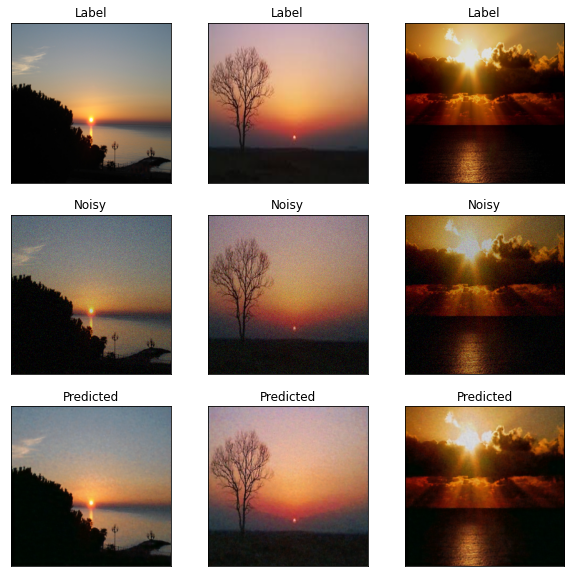

In [ ]:
n = 3
plt.figure(figsize=(10, 10))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("Label")
    plt.imshow(tf.squeeze((norm_test[i]*255).astype('uint8')))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + n + 1)
    plt.title("Noisy")
    plt.imshow(tf.squeeze((x_test[i]*255).astype('uint8')))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("Predicted")
    plt.imshow(tf.squeeze((test_pred[i]*255).astype('uint8')))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()